In [1]:
""""""
import torch
import pathlib
import cv2 as cv
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.nn import functional as F
import random
torch.set_default_dtype(torch.float32)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
batch_size = 32
num_classes = 32

In [2]:
"""基于注意力机制集成学习的双卷积神经网络用于分类任务"""
class DoubleConv(nn.Module):
    # 双卷积
    def __init__(self, num_classes=10):
        super(DoubleConv, self).__init__()
        # 第一个卷积层
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # 第二个卷积层
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.attention = nn.Sequential(
            nn.Linear(32 * 32 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

        # 分类器
        self.fc = nn.Linear(32 * 32 * 32, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        # 对卷积后的特征进行展开，用于注意力机制和分类器
        x_flat = x.view(x.size(0), -1)

        # 应用注意力机制
        attention_weights = self.attention(x_flat) # 特征权重计算
        x_attended = x_flat * attention_weights # 加权
        # 使用注意力加权后的特征进行分类
        prob = self.fc(x_attended)
        return prob

In [3]:
class Car(Dataset):  # 加载数据集
    def __init__(self, path):
        data_root = pathlib.Path(path)
        all_image_paths = list(data_root.glob('*/*'))
        self.all_image_paths = [str(path) for path in all_image_paths]
        label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
        label_to_index = dict((label, index) for index, label in enumerate(label_names))
        print(label_to_index)
        self.all_image_labels = [label_to_index[path.parent.name] for path in all_image_paths]
        self.mean = np.array(mean).reshape((1, 1, 3))
        self.std = np.array(std).reshape((1, 1, 3))
        
        # 将两个列表合并为元组的列表
        combined = list(zip(self.all_image_labels, self.all_image_paths))
        # 随机打乱列表
        random.shuffle(combined)
        # 恢复打乱后的列表到原始的两个列表
        self.all_image_labels, self.all_image_paths = zip(*combined)

        print(self.all_image_labels)

    def __getitem__(self, index):
        img = cv.imread(self.all_image_paths[index])
        img = cv.resize(img, (32, 32))
        img = img / 255.
        img = (img - self.mean) / self.std
        img = np.transpose(img, [2, 0, 1])
        label = self.all_image_labels[index]
        img = torch.tensor(img, dtype=torch.float32)
        label = torch.tensor(label)
        return img, label

    def __len__(self):
        return len(self.all_image_paths)


data = Car("./Car_Logo_Dataset")  # 读取车标

{'1-Volvo': 0, '10-BMW': 1, '11-Jeep': 2, '12-Kia': 3, '13-Citroen': 4, '14-Land Rover': 5, '15-Lexus': 6, '16-Mazda': 7, '17-Mercedes': 8, '18-Mini': 9, '19-Mitsubishi': 10, '2-Volkswagen': 11, '20-Nissan': 12, '21-Opel': 13, '22-Peugeot': 14, '23-Renault': 15, '24-Seat': 16, '25-GMC': 17, '26-Smart': 18, '27-Subaru': 19, '28-Suzuki': 20, '29-Tesla': 21, '3-Hyundai': 22, '30-Toyota': 23, '31-Alfa Romeo': 24, '32-Acura': 25, '4-Lancia': 26, '5-Dacia': 27, '6-Daewoo': 28, '7-Ford': 29, '8-Skoda': 30, '9-Honda': 31}
(12, 11, 31, 17, 30, 15, 5, 22, 6, 22, 2, 22, 1, 30, 26, 19, 23, 6, 20, 18, 3, 27, 2, 26, 3, 0, 30, 9, 26, 29, 20, 1, 18, 15, 1, 1, 4, 26, 4, 17, 3, 5, 3, 9, 26, 10, 25, 5, 7, 11, 3, 8, 22, 25, 2, 0, 31, 2, 15, 9, 15, 23, 16, 26, 2, 25, 22, 6, 0, 10, 29, 3, 20, 10, 8, 16, 30, 4, 12, 2, 16, 11, 18, 31, 21, 31, 8, 13, 25, 28, 2, 19, 2, 6, 5, 12, 13, 20, 19, 26, 26, 21, 24, 28, 5, 31, 9, 2, 19, 2, 13, 21, 30, 6, 1, 8, 7, 30, 12, 9, 10, 21, 14, 13, 24, 23, 0, 21, 16, 16, 13, 29, 

In [4]:
"""定义损失函数"""
def cross_entropy_loss(logits, targets):
    # 使用稳定的softmax函数
    # 计算对数概率
    log_probs = F.log_softmax(logits, dim=1)
    
    # 获取正确标签的对数概率值
    log_probs_for_labels = log_probs[range(len(targets)), targets]
    
    # 计算损失
    loss = -torch.mean(log_probs_for_labels)

    return loss

In [5]:
""" 分割数据集 """
train_size = int(len(data) * 0.7)  # 训练集
vaild_size = int(len(data) * 0.15)  # 验证集
test_size = len(data) - train_size - vaild_size  # 测试集

train_dataset, vaild_dataset, test_dataset = random_split(data, [train_size, vaild_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
validate_loader = DataLoader(vaild_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

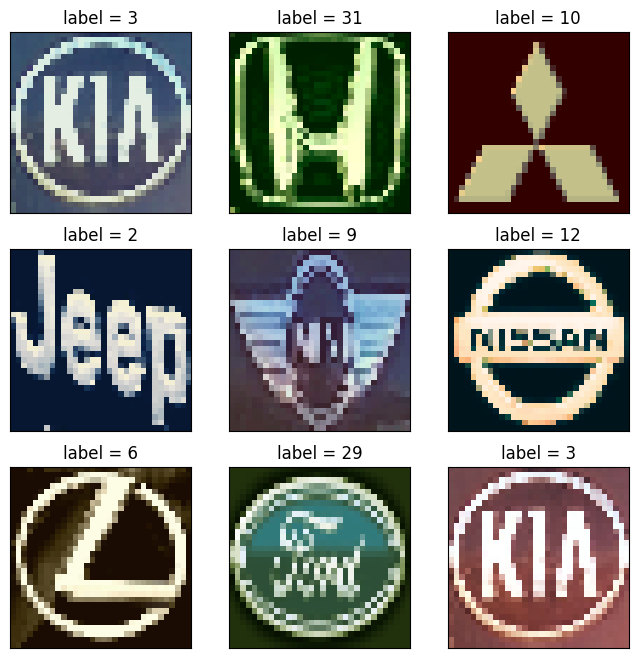

In [6]:
import random
from matplotlib import pyplot as plt


def denorm(img):
    for i in range(img.shape[0]):
        img[i] = img[i] * std[i] + mean[i]
    img = torch.clamp(img, 0., 1.)
    return img


plt.figure(figsize=(8, 8))
for i in range(9):
    img, label = train_dataset[random.randint(0, len(train_dataset))]
    img = denorm(img)
    img = img.permute(1, 2, 0)
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img.numpy()[:, :, ::-1])
    ax.set_title("label = %d" % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [8]:
"""初始化DoubleConv网络"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DoubleConv(num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device

device(type='cuda', index=0)

In [9]:
def Evaluation(y_pred, y_true):
    """
    :param y_pred: 
    :param y_true: 
    :return: 
    """
    tp = (y_pred[(y_true == 1)]).sum()
    tn = (y_pred[(y_true != 1)]).sum()
    fp = ((y_pred == 1)[(y_true != 1)]).sum()
    fn = ((y_pred != 1)[(y_true == 1)]).sum()

    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else (tp + tn + fp + fn)
    pre = tp / (tp + fp) if (tp+fp) else (tp+fp)
    recall =  tp / (tp + fn) if (tp+fn) else (tp+fn)
    return acc.cpu().detach().numpy(), pre.cpu().detach().numpy(), recall.cpu().detach().numpy()

In [10]:
"""对train_loader使用DoubleConv网络"""

train_losses = []
train_scores = [[] for _ in range(3)]
vail_losses = []
vail_scores = [[] for _ in range(3)]
for epoch in range(10):
    loss_temp = []
    model.train()
    acc_temp = []
    pre_temp = []
    recall_temp = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).to(device)  # 网络计算
        optimizer.zero_grad()
        loss = cross_entropy_loss(outputs, labels)  # 计算损失函数 
        loss_temp.append(loss.cpu().detach().numpy())
        loss.backward()
        acc, pre, recall = Evaluation(outputs, labels)
        acc_temp.append(acc)
        pre_temp.append(pre)
        recall_temp.append(recall)
        optimizer.step()
        if i % 10 == 0:
            print("epoch:{}, batch:{}, loss:{}".format(epoch, i, loss))
    train_losses.append(sum(loss_temp) / len(loss_temp))
    train_scores[0].append(sum(acc_temp) / len(acc_temp))
    train_scores[1].append(sum(pre_temp) / len(pre_temp))
    train_scores[2].append(sum(recall_temp) / len(recall_temp))
    
    
    model.eval()
    acc = []
    total = 0
    correct = 0
    loss_temp = []
    acc_temp = []
    pre_temp = []
    recall_temp = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            loss = cross_entropy_loss(outputs, labels)  # 计算损失函数 
            loss_temp.append(loss.cpu().detach().numpy())
            acc, pre, recall = Evaluation(outputs, labels)
            acc_temp.append(acc)
            pre_temp.append(pre)
            recall_temp.append(recall)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    print("batch:{},auc:{}%".format(total, correct / total * 100))
    vail_losses.append(sum(loss_temp) / len(loss_temp))
    vail_scores[0].append(sum(acc_temp) / len(acc_temp))
    vail_scores[1].append(sum(pre_temp) / len(pre_temp))
    vail_scores[2].append(sum(recall_temp) / len(recall_temp))

epoch:0, batch:0, loss:3.4728612899780273
epoch:0, batch:10, loss:0.4177435040473938
batch:81,auc:95.06172943115234%
epoch:1, batch:0, loss:0.24318066239356995
epoch:1, batch:10, loss:0.008725965395569801
batch:81,auc:100.0%
epoch:2, batch:0, loss:0.00353256706148386
epoch:2, batch:10, loss:7.690882193855941e-05
batch:81,auc:100.0%
epoch:3, batch:0, loss:5.21386245964095e-05
epoch:3, batch:10, loss:6.981068963796133e-06
batch:81,auc:100.0%
epoch:4, batch:0, loss:1.0437734090373851e-05
epoch:4, batch:10, loss:3.572521336536738e-06
batch:81,auc:100.0%
epoch:5, batch:0, loss:6.235957698663697e-06
epoch:5, batch:10, loss:2.7082669475930743e-06
batch:81,auc:100.0%
epoch:6, batch:0, loss:5.066275662102271e-06
epoch:6, batch:10, loss:2.287314828208764e-06
batch:81,auc:100.0%
epoch:7, batch:0, loss:4.563383299682755e-06
epoch:7, batch:10, loss:2.067525201709941e-06
batch:81,auc:100.0%
epoch:8, batch:0, loss:4.27654731538496e-06
epoch:8, batch:10, loss:1.914790118462406e-06
batch:81,auc:100.0%


In [11]:
torch.save(model.state_dict(), "./Car.pth")

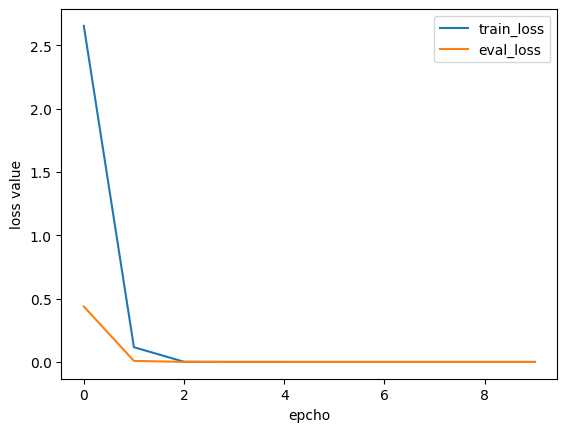

In [12]:
plt.plot(range(len(train_losses)), train_losses, label='train_loss')
plt.plot(range(len(vail_losses)), vail_losses, label='eval_loss')
plt.xlabel("epcho")
plt.ylabel("loss value")
plt.legend()
plt.show()

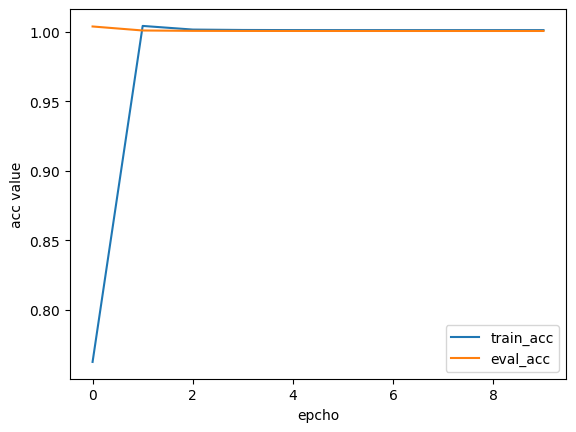

In [13]:
plt.plot(range(len(train_scores[0])), train_scores[0], label='train_acc')
plt.plot(range(len(vail_scores[0])), vail_scores[0], label='eval_acc')
plt.xlabel("epcho")
plt.ylabel("acc value")
plt.legend()
plt.show()

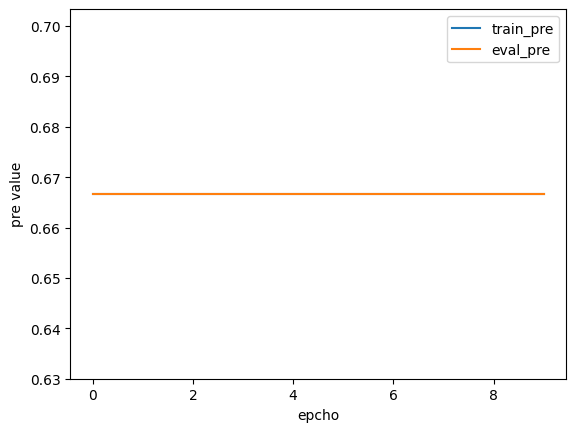

In [14]:
plt.plot(range(len(train_scores[1])), train_scores[1], label='train_pre')
plt.plot(range(len(vail_scores[1])), vail_scores[1], label='eval_pre')
plt.xlabel("epcho")
plt.ylabel("pre value")
plt.legend()
plt.show()

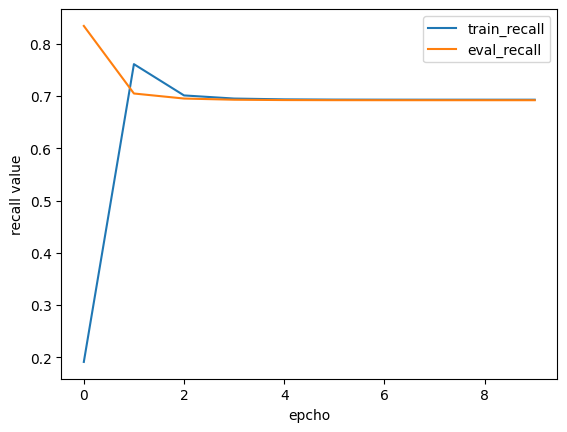

In [15]:
plt.plot(range(len(train_scores[2])), train_scores[2], label='train_recall')
plt.plot(range(len(vail_scores[2])), vail_scores[2], label='eval_recall')
plt.xlabel("epcho")
plt.ylabel("recall value")
plt.legend()
plt.show()

In [76]:
"""保存模型"""
PATH = './cifar_net.pth'
# torch.save(model.state_dict(), PATH)

In [77]:
"""加载模型"""
model = DoubleConv(num_classes).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

roc-auc曲线

In [78]:
import torch
import numpy as np

In [27]:
"""测试图片"""
with torch.no_grad():
    total = 0
    correct = 0
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted_prob = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
print("batch:{},auc:{}%".format(total, correct / total * 100))

batch:83,auc:100.0%
